In [ ]:
# ==========================================
# Library Imports
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, GRU
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
# ==========================================
# Data Loading and Visualization
# ==========================================

# Load the dataset (make sure the file is in the current directory)
df = pd.read_csv("BTC.csv")

# Check for missing values
print("🔍 Missing values per column:")
print(df.isnull().sum())


🔍 Missing values per column:
ticker    0
date      0
open      0
high      0
low       0
close     0
dtype: int64


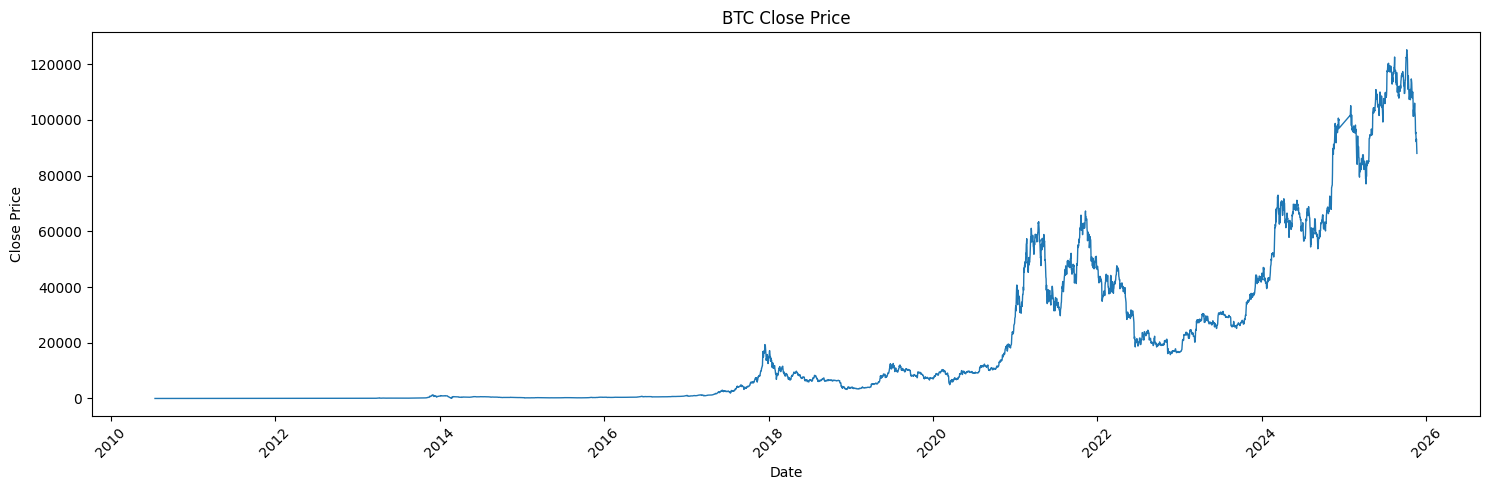

In [ ]:
# Visualize the closing price history
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

prices = df["close"].values.reshape(-1, 1)

plt.figure(figsize=(15, 5))

plt.plot(df["date"], prices, linewidth=1)

plt.title("BTC Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

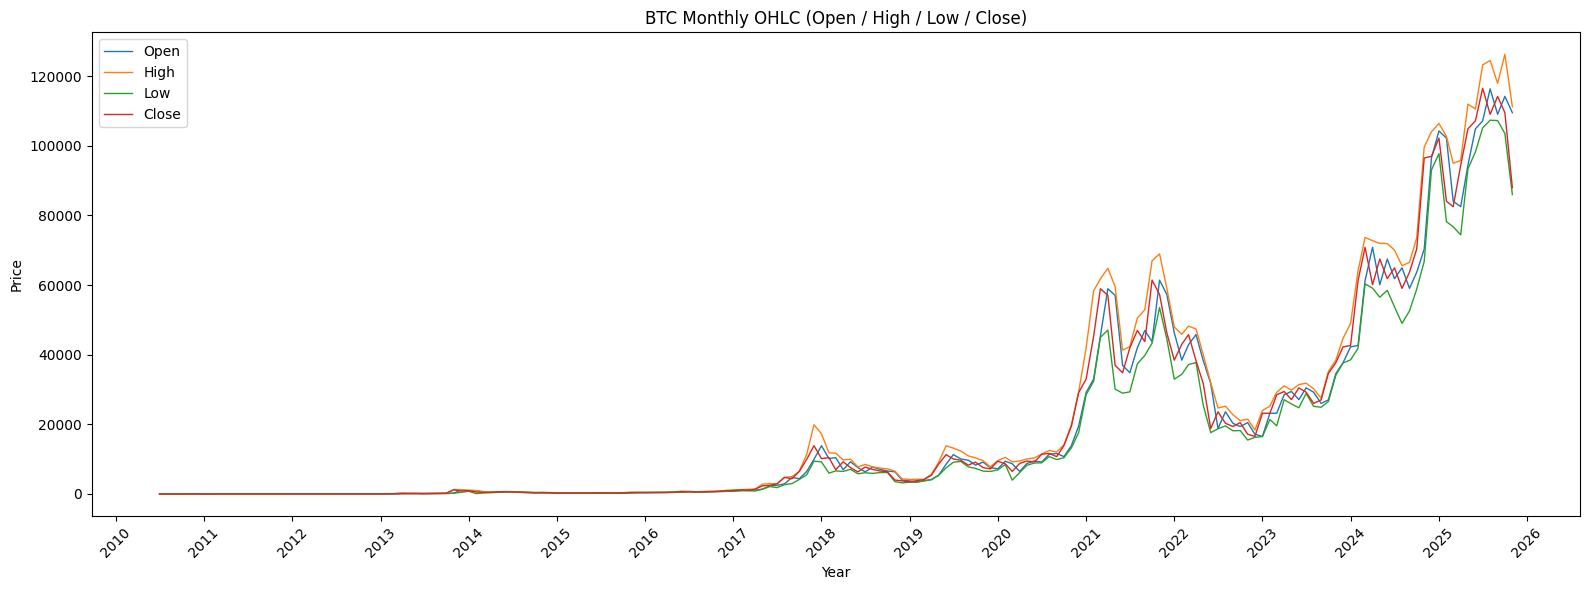

In [ ]:
# ==========================================
# Plot Monthly OHLC Curves
# ==========================================

df["year_month"] = df["date"].dt.to_period("M") 

monthly_open = df.groupby("year_month")["open"].first()
monthly_close = df.groupby("year_month")["close"].last()
monthly_high = df.groupby("year_month")["high"].max()
monthly_low = df.groupby("year_month")["low"].min()

x_labels = monthly_open.index.to_timestamp()

plt.figure(figsize=(16,6))

plt.plot(x_labels, monthly_open,  label="Open",  linewidth=1)
plt.plot(x_labels, monthly_high,  label="High",  linewidth=1)
plt.plot(x_labels, monthly_low,   label="Low",   linewidth=1)
plt.plot(x_labels, monthly_close, label="Close", linewidth=1)

plt.title("BTC Monthly OHLC (Open / High / Low / Close)")
plt.xlabel("Year")
plt.ylabel("Price")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# Data Preprocessing with Univariate
# ==========================================

prices = df["close"].values.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

# ==========================================
# Create Sliding Window Dataset
# ==========================================
def create_dataset(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

WINDOW = 20
X, y = create_dataset(scaled_prices, WINDOW)
X = X.reshape((X.shape[0], WINDOW, 1))

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# ================================================
# Model Building and Training With Early Stopping
# ================================================

# RNN model
rnn_model = Sequential([
    SimpleRNN(32, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(1)
])

rnn_model.compile(optimizer="adam", loss="mse")
rnn_model.summary()

history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# LSTM model
lstm_model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# GRU Model
gru_model = Sequential([
    GRU(32, input_shape=(WINDOW, 1)),
    Dense(1)
])

gru_model.compile(optimizer="adam", loss="mse")

history_gru = gru_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0323
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1317e-04 - val_loss: 0.0144
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8704e-04 - val_loss: 0.0101
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2157e-04 - val_loss: 0.0089
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1375e-04 - val_loss: 0.0056
Epoch 6/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1431e-04 - val_loss: 0.0054
Epoch 7/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7383e-05 - val_loss: 0.0030
Epoch 8/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1795e-05 - val_loss: 0.0047
Epoch 9/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9527e-05 - val_loss: 0.0029
Epoch 10/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7642e-05 - val_loss: 0.0016
Epoch 11/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1405e-05 - val_loss: 0.0025
Epoch 12/40


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - val_loss: 8.6581e-04
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0986e-04 - val_loss: 0.0012
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8046e-04 - val_loss: 0.0018
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3239e-04 - val_loss: 0.0015
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1273e-04 - val_loss: 0.0017
Epoch 6/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1411e-04 - val_loss: 9.6789e-04
Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 4.0284e-04
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4397e-05 - val_loss: 3.9965e-04
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5212e-05 - val_loss: 2.6837e-04
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6512e-05 - val_loss: 3.1416e-04
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2869e-05 - val_loss: 2

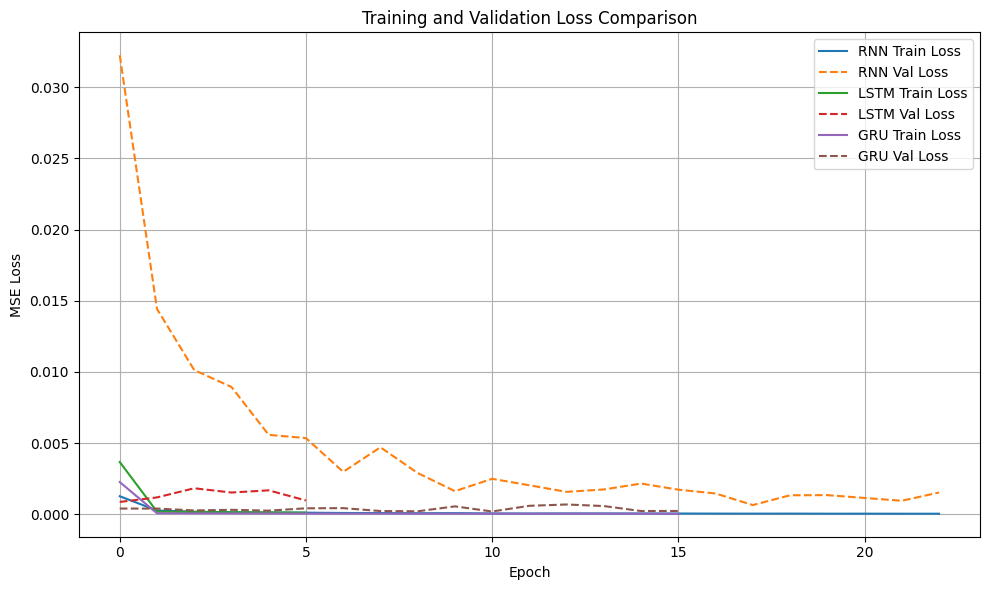

In [48]:
plt.figure(figsize=(10, 6))

# RNN
plt.plot(history_rnn.history["loss"], label="RNN Train Loss")
plt.plot(history_rnn.history["val_loss"], linestyle="--", label="RNN Val Loss")

# LSTM
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss")
plt.plot(history_lstm.history["val_loss"], linestyle="--", label="LSTM Val Loss")

# GRU
plt.plot(history_gru.history["loss"], label="GRU Train Loss")
plt.plot(history_gru.history["val_loss"], linestyle="--", label="GRU Val Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# RNN Prediction
rnn_pred = rnn_model.predict(X_test)
rnn_pred_price = scaler.inverse_transform(rnn_pred)
y_test_price = scaler.inverse_transform(y_test)

# LSTM Prediction
lstm_pred = lstm_model.predict(X_test)
lstm_pred_price = scaler.inverse_transform(lstm_pred)

# GRU Prediction
gru_pred = gru_model.predict(X_test)
gru_pred_price = scaler.inverse_transform(gru_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


====== RNN Evaluation ======
MAE  = 2443.652065
RMSE = 3185.882088

====== LSTM Evaluation ======
MAE  = 2689.831082
RMSE = 3683.162409

====== GRU Evaluation ======
MAE  = 1210.301977
RMSE = 1752.843860

📊 Metrics Summary Table:
              MAE         RMSE
RNN   2443.652065  3185.882088
LSTM  2689.831082  3683.162409
GRU   1210.301977  1752.843860


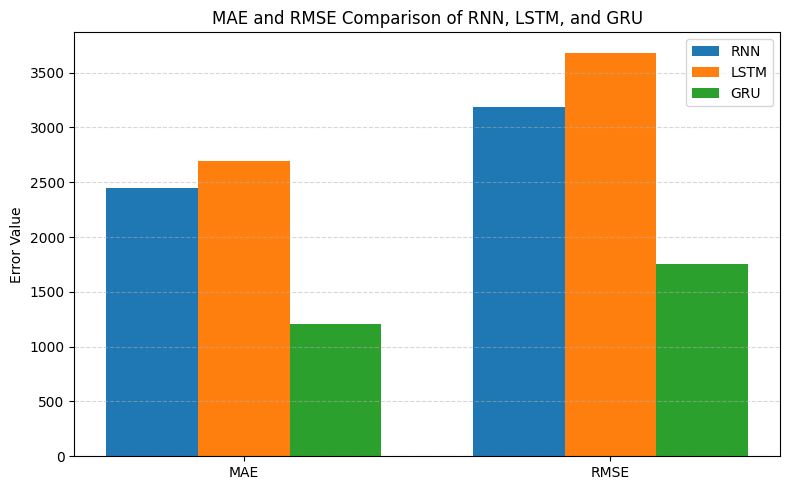

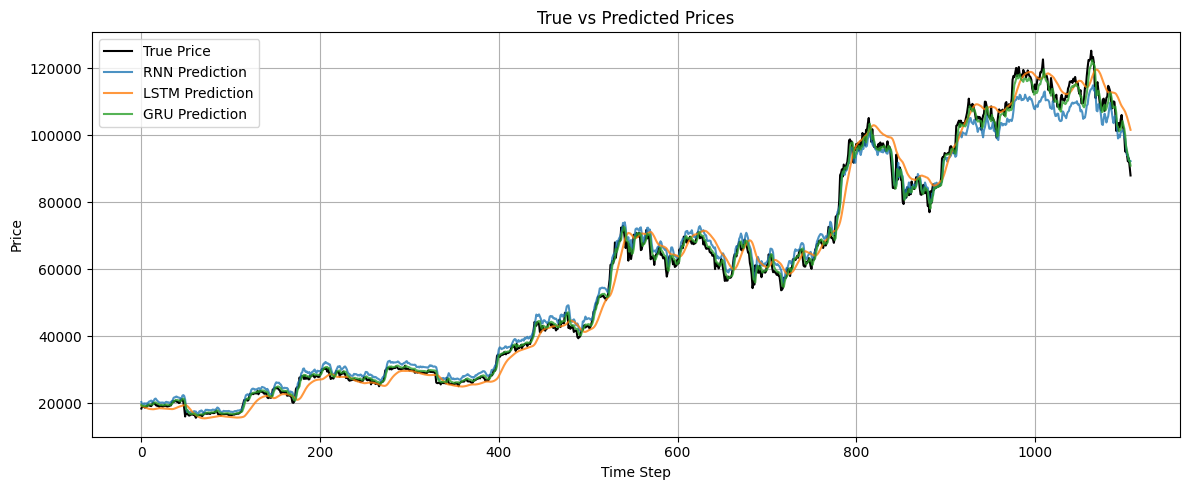

In [ ]:
# ===============================
# Evaluation function
# ===============================
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"====== {model_name} Evaluation ======")
    print(f"MAE  = {mae:.6f}")
    print(f"RMSE = {rmse:.6f}\n")

    return {
        "MAE": mae,
        "RMSE": rmse
    }


# ===============================
# Evaluate models
# ===============================
metrics_rnn  = evaluate(y_test_price, rnn_pred_price,  "RNN")
metrics_lstm = evaluate(y_test_price, lstm_pred_price, "LSTM")
metrics_gru  = evaluate(y_test_price, gru_pred_price,  "GRU")


# ===============================
# Create metrics table
# ===============================
df_metrics = pd.DataFrame(
    [metrics_rnn, metrics_lstm, metrics_gru],
    index=["RNN", "LSTM", "GRU"]
)

print("📊 Metrics Summary Table:")
print(df_metrics)


# ================================
# Bar chart: MAE & RMSE comparison
# ================================
labels = ["MAE", "RMSE"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, df_metrics.loc["RNN", labels],  width, label="RNN")
plt.bar(x,         df_metrics.loc["LSTM", labels], width, label="LSTM")
plt.bar(x + width, df_metrics.loc["GRU", labels],  width, label="GRU")

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("MAE and RMSE Comparison of RNN, LSTM, and GRU")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ===============================
# Line plot: true vs predicted
# ===============================
plt.figure(figsize=(12, 5))
plt.plot(y_test_price, label="True Price", color="black")
plt.plot(rnn_pred_price, label="RNN Prediction", alpha=0.8)
plt.plot(lstm_pred_price, label="LSTM Prediction", alpha=0.8)
plt.plot(gru_pred_price, label="GRU Prediction", alpha=0.8)

plt.title("True vs Predicted Prices")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# Data Preprocessing with multivariate
# ==========================================
features = df[["open", "high", "low", "close"]].values

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

def create_dataset_multi(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window, 3])
    return np.array(X), np.array(y)

WINDOW = 20
X, y = create_dataset_multi(scaled_features, WINDOW)

X = X.reshape((X.shape[0], WINDOW, 4))

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("\nTrain samples:", len(X_train))
print("Test samples:", len(X_test))

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

rnn_model = Sequential([
    SimpleRNN(64, return_sequences=False, input_shape=(WINDOW, 4)),
    Dense(1)
])

rnn_model.compile(optimizer="adam", loss="mse")
print("\n===== RNN Model Summary =====")
rnn_model.summary()

history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, 4)),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()


history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

gru_model = Sequential([
    GRU(64, return_sequences=False, input_shape=(WINDOW, 4)),
    Dense(1)
])

gru_model.compile(optimizer="adam", loss="mse")
print("\n===== GRU Model Summary =====")
gru_model.summary()

history_gru = gru_model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Train samples: 4429
Test samples: 1108

===== RNN Model Summary =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8154e-05 - val_loss: 0.0052
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8773e-05 - val_loss: 0.0029
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0242e-04 - val_loss: 0.0036
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5630e-05 - val_loss: 0.0017
Epoch 6/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3040e-05 - val_loss: 0.0046
Epoch 7/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6401e-05 - val_loss: 0.0052
Epoch 8/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7913e-05 - val_loss: 0.0012
Epoch 9/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0331e-05 - val_loss: 0.0020
Epoch 10/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6427e-05 - val_loss: 0.0014
Epoch 11/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7842e-05 - val_loss: 0.0016
Epoch 12/40


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012 - val_loss: 8.5186e-04
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1776e-05 - val_loss: 5.7959e-04
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2918e-05 - val_loss: 7.0086e-04
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9975e-05 - val_loss: 0.0017
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3844e-05 - val_loss: 7.2390e-04
Epoch 6/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0509e-05 - val_loss: 3.7371e-04
Epoch 7/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2500e-05 - val_loss: 5.2370e-04
Epoch 8/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7492e-05 - val_loss: 6.9070e-04
Epoch 9/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5891e-05 - val_loss: 2.8770e-04
Epoch 10/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0133e-05 - val_loss: 6.7090e-04
Epoch 11/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0793

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                    │ (None, 64)             │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,505 (52.75 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0018 - val_loss: 3.0532e-04
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2024e-05 - val_loss: 3.3603e-04
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5026e-05 - val_loss: 3.3105e-04
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7299e-05 - val_loss: 2.0321e-04
Epoch 5/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4607e-05 - val_loss: 2.0774e-04
Epoch 6/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3858e-05 - val_loss: 3.5848e-04
Epoch 7/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1348e-05 - val_loss: 1.9259e-04
Epoch 8/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0634e-05 - val_loss: 2.7442e-04
Epoch 9/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8237e-05 - val_loss: 4.9558e-04
Epoch 10/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9205e-05 - val_loss: 3.3781e-04
Epoch 11/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
====== RNN Evaluation ======
MAE  = 2755.141670
RMSE = 3309.770840

====== LSTM Evaluation ======
MAE  = 1158.956296
RMSE = 1682.185086

====== GRU Evaluation ======
MAE  = 1021.922169
RMSE = 1520.730762

📊 Metrics Summary Table:
              MAE         RMSE
RNN   2755.141670  3309.770840
LSTM  1158.956296  1682.185086
GRU   1021.922169  1520.730762


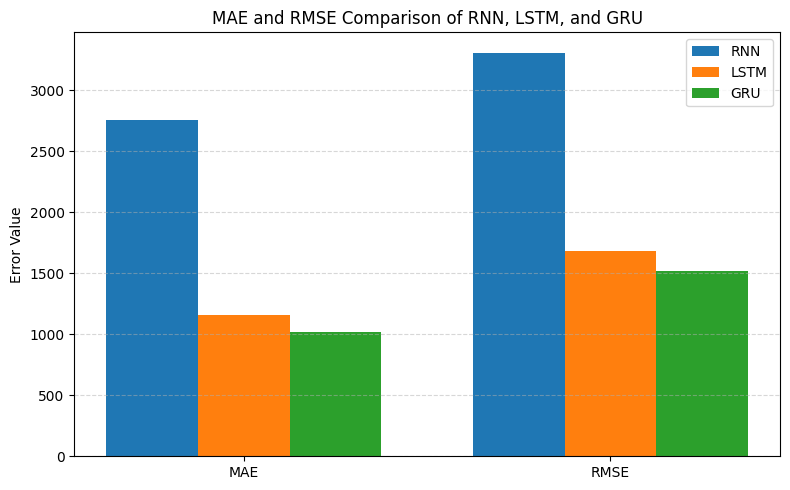

In [ ]:
rnn_pred = rnn_model.predict(X_test)

dummy_rnn = np.zeros((len(rnn_pred), 4))
dummy_rnn[:, 3] = rnn_pred[:, 0]

dummy_true = np.zeros((len(y_test), 4))
dummy_true[:, 3] = y_test

rnn_pred_price = scaler.inverse_transform(dummy_rnn)[:, 3]
y_test_price = scaler.inverse_transform(dummy_true)[:, 3]

lstm_pred = lstm_model.predict(X_test)

dummy_lstm = np.zeros((len(lstm_pred), 4))
dummy_lstm[:, 3] = lstm_pred[:, 0]

lstm_pred_price = scaler.inverse_transform(dummy_lstm)[:, 3]


gru_pred = gru_model.predict(X_test)

dummy_gru = np.zeros((len(gru_pred), 4))
dummy_gru[:, 3] = gru_pred[:, 0]

gru_pred_price = scaler.inverse_transform(dummy_gru)[:, 3]


metrics_rnn  = evaluate(y_test_price, rnn_pred_price,  "RNN")
metrics_lstm = evaluate(y_test_price, lstm_pred_price, "LSTM")
metrics_gru  = evaluate(y_test_price, gru_pred_price,  "GRU")


# ===============================
# Create metrics table
# ===============================
df_metrics = pd.DataFrame(
    [metrics_rnn, metrics_lstm, metrics_gru],
    index=["RNN", "LSTM", "GRU"]
)

print("📊 Metrics Summary Table:")
print(df_metrics)


# ===============================
# Bar chart: MAE & RMSE comparison
# ===============================
labels = ["MAE", "RMSE"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, df_metrics.loc["RNN", labels],  width, label="RNN")
plt.bar(x,         df_metrics.loc["LSTM", labels], width, label="LSTM")
plt.bar(x + width, df_metrics.loc["GRU", labels],  width, label="GRU")

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("MAE and RMSE Comparison of RNN, LSTM, and GRU")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

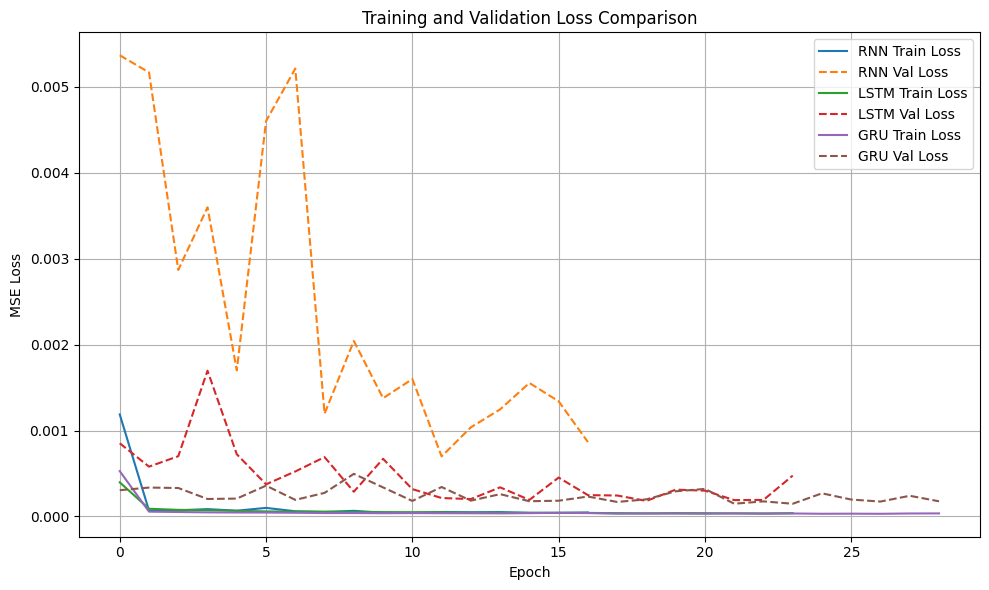

In [ ]:
plt.figure(figsize=(10, 6))

# RNN
plt.plot(history_rnn.history["loss"], label="RNN Train Loss")
plt.plot(history_rnn.history["val_loss"], linestyle="--", label="RNN Val Loss")

# LSTM
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss")
plt.plot(history_lstm.history["val_loss"], linestyle="--", label="LSTM Val Loss")

# GRU
plt.plot(history_gru.history["loss"], label="GRU Train Loss")
plt.plot(history_gru.history["val_loss"], linestyle="--", label="GRU Val Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

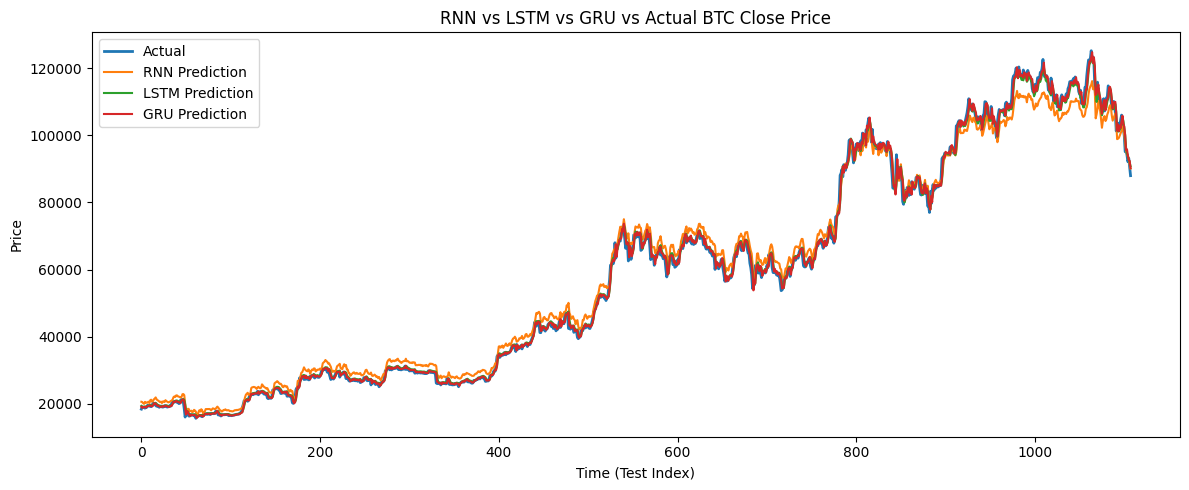

In [54]:
# Plot Comparison
plt.figure(figsize=(12, 5))
plt.plot(y_test_price, label="Actual", linewidth=2)
plt.plot(rnn_pred_price, label="RNN Prediction")
plt.plot(lstm_pred_price, label="LSTM Prediction")
plt.plot(gru_pred_price, label="GRU Prediction")
plt.title("RNN vs LSTM vs GRU vs Actual BTC Close Price")
plt.xlabel("Time (Test Index)")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# Determine the Optimal Sliding Window Size
# ==========================================
def create_dataset_multi(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window, 3])
    return np.array(X), np.array(y)

def evaluate_metrics(true, pred):
    mae  = np.mean(np.abs(true - pred))
    mse  = np.mean((true - pred)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    ss_res = np.sum((true - pred)**2)
    ss_tot = np.sum((true - np.mean(true))**2)
    r2 = 1 - ss_res / ss_tot
    return mae, rmse, r2, mape

window_sizes = [10, 20, 40, 60, 80]

results = {
    "window": [],
    "RNN_RMSE": [], "LSTM_RMSE": [], "GRU_RMSE": [],
    "RNN_R2": [],   "LSTM_R2": [],   "GRU_R2": [],
}

# load BTC data
df = pd.read_csv("BTC.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

features = df[["open", "high", "low", "close"]].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

for WINDOW in window_sizes:
    print(f"\n\n===== Testing Window Size = {WINDOW} =====")

    # create dataset
    X, y = create_dataset_multi(scaled_features, WINDOW)
    X = X.reshape((X.shape[0], WINDOW, 4))

    # train-test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # prepare inverse transform template
    dummy_true = np.zeros((len(y_test), 4))
    dummy_true[:, 3] = y_test
    y_test_price = scaler.inverse_transform(dummy_true)[:, 3]

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # RNN
    rnn_model = Sequential([
        SimpleRNN(64, input_shape=(WINDOW, 4)),
        Dense(1)
    ])
    rnn_model.compile(loss="mse", optimizer="adam")
    rnn_model.fit(X_train, y_train, epochs=40, batch_size=32,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop], verbose=0)

    rnn_pred = rnn_model.predict(X_test)
    dummy = np.zeros((len(rnn_pred), 4))
    dummy[:, 3] = rnn_pred[:, 0]
    rnn_pred_price = scaler.inverse_transform(dummy)[:, 3]

    mae, rmse, r2, mape = evaluate_metrics(y_test_price, rnn_pred_price)
    results["RNN_RMSE"].append(rmse)
    results["RNN_R2"].append(r2)

    # LSTM
    lstm_model = Sequential([
        LSTM(64, input_shape=(WINDOW, 4)),
        Dense(1)
    ])
    lstm_model.compile(loss="mse", optimizer="adam")
    lstm_model.fit(X_train, y_train, epochs=40, batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stop], verbose=0)

    lstm_pred = lstm_model.predict(X_test)
    dummy[:, 3] = lstm_pred[:, 0]
    lstm_pred_price = scaler.inverse_transform(dummy)[:, 3]

    mae, rmse, r2, mape = evaluate_metrics(y_test_price, lstm_pred_price)
    results["LSTM_RMSE"].append(rmse)
    results["LSTM_R2"].append(r2)

    # GRU
    gru_model = Sequential([
        GRU(64, input_shape=(WINDOW, 4)),
        Dense(1)
    ])
    gru_model.compile(loss="mse", optimizer="adam")
    gru_model.fit(X_train, y_train, epochs=40, batch_size=32,
                  validation_data=(X_test, y_test),
                  callbacks=[early_stop], verbose=0)

    gru_pred = gru_model.predict(X_test)
    dummy[:, 3] = gru_pred[:, 0]
    gru_pred_price = scaler.inverse_transform(dummy)[:, 3]

    mae, rmse, r2, mape = evaluate_metrics(y_test_price, gru_pred_price)
    results["GRU_RMSE"].append(rmse)
    results["GRU_R2"].append(r2)

    results["window"].append(WINDOW)

# =========================
# Convert to DataFrame
# =========================
results_df = pd.DataFrame(results)
print("\n===== Window Size Experiment Results =====")
print(results_df)



===== Testing Window Size = 10 =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


===== Testing Window Size = 20 =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


===== Testing Window Size = 40 =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


===== Testing Window Size = 60 =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


===== Testing Window Size = 80 =====


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/Users/zhuxiuwen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

===== Window Size Experiment Results =====
   window     RNN_RMSE    LSTM_RMSE     GRU_RMSE    RNN_R2   LSTM_R2    GRU_R2
0      10  1686.840972  1753.648123  1644.262411  0.997393  0.997183  0.997523
1      20  1713.619753  1895.104282  1747.453115  0.997308  0.996707  0.997200
2      40  2203.234956  1873.054192  1684.789785  0.995542  0.996778  0.997393
3      60  1776.831099  1891.426546  1958.601295  0.997096  0.996709  0.996471
4      80  2207.700176  1877.627690  1687.109531  0.995509  0.996751  0.997377


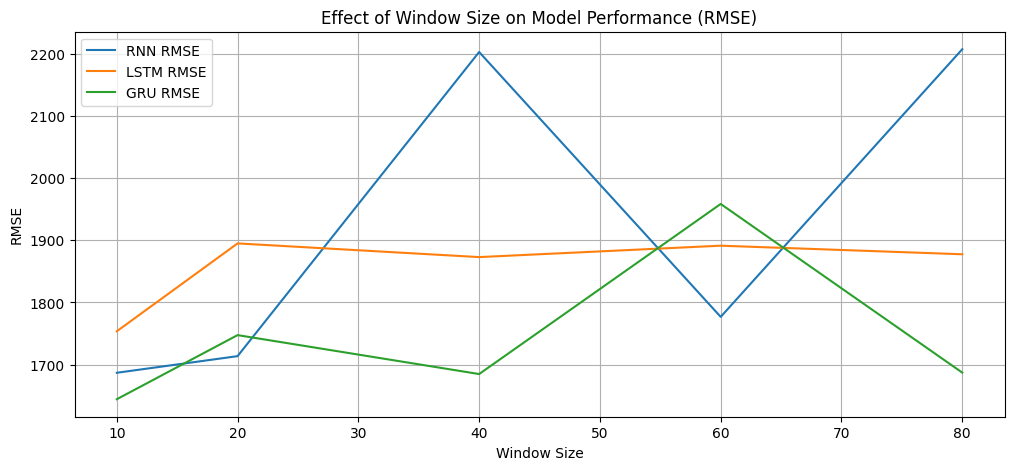

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(results_df["window"], results_df["RNN_RMSE"], label="RNN RMSE")
plt.plot(results_df["window"], results_df["LSTM_RMSE"], label="LSTM RMSE")
plt.plot(results_df["window"], results_df["GRU_RMSE"], label="GRU RMSE")

plt.title("Effect of Window Size on Model Performance (RMSE)")
plt.xlabel("Window Size")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()